# Data Transformation and Price Analysis of Airbnb Listings in Europe


## Importing Required Libraries


In [1]:
import pandas as pd
import folium
from IPython.display import HTML
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, kstest
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

### Loading Data from Google Sheets


In [4]:
# Your Google Sheets ID and sheet name
sheet_id = "1ecopK6oyyb4d_7-QLrCr8YlgFrCetHU7-VQfnYej7JY"
sheet_name = "Sheet1"  # Replace with the actual sheet name if it's different

# Construct the URL to access the sheet's CSV export format
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read the data into a Pandas DataFrame
data = pd.read_csv(url)
data.head()

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,0,194.033698,Private room,False,True,2,False,1,0,10,93,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772
1,1,344.245776,Private room,False,True,4,False,0,0,8,85,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432
2,2,264.101422,Private room,False,True,2,False,0,1,9,87,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103
3,3,433.529398,Private room,False,True,4,False,0,1,9,90,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663
4,4,485.552926,Private room,False,True,2,True,0,0,10,98,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508


### Loading and Merging Data from Multiple Google Sheets


In [7]:

# List of all sheet names
sheet_names = [
    "amsterdam_weekdays", "amsterdam_weekends", "athen_weekdays", "athen_weekends", "berlin_weekends",
    "barcelona_weekdays", "barcelona_weekends", "berlin_weekdays", "budapest_weekends", 
    "budapest_weekdays", "lisbon_weekends", "lisbon_weekdays", "london_weekdays", 
    "london_weekends", "paris_weekdays", "paris_weekends", "rome_weekends", 
    "rome_weekdays", "vienna_weekdays", "vienna_weekends"
]

# Initialize an empty list to store DataFrames
all_sheets = []

# Loop over each sheet name and load the data
for sheet_name in sheet_names:
    # Construct the URL for each sheet
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    
    try:
        # Load the sheet into a DataFrame and append it to the list
        df = pd.read_csv(url)
        df['sheet_name'] = sheet_name  # Optional: add a column to indicate the sheet name
        all_sheets.append(df)
    except Exception as e:
        print(f"Error loading sheet {sheet_name}: {e}")

# Concatenate all sheets into one DataFrame
merged_data = pd.concat(all_sheets, ignore_index=True)


In [9]:
merged_data.head()

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,...,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,sheet_name
0,0,194.033698,Private room,False,True,2,False,1,0,10,...,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam_weekdays
1,1,344.245776,Private room,False,True,4,False,0,0,8,...,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam_weekdays
2,2,264.101422,Private room,False,True,2,False,0,1,9,...,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam_weekdays
3,3,433.529398,Private room,False,True,4,False,0,1,9,...,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam_weekdays
4,4,485.552926,Private room,False,True,2,True,0,0,10,...,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam_weekdays


### Preprocessing: Adding City, Country, and Day Type to Airbnb Data


In [12]:
# Initialize an empty list to store DataFrames
dfs = []

# City to country mapping
city_country_map = {
    "amsterdam": "Netherlands",
    "athens": "Greece",
    "berlin": "Germany",
    "barcelona": "Spain",
    "budapest": "Hungary",
    "lisbon": "Portugal",
    "london": "United Kingdom",
    "paris": "France",
    "rome": "Italy",
    "vienna": "Austria",
}

# Loop through each sheet name and read it into a DataFrame
for sheet_name in sheet_names:
    city, weekday_weekend = sheet_name.split('_')  # Split to get city and weekdays/weekends
    url = f"https://docs.google.com/spreadsheets/d/1ecopK6oyyb4d_7-QLrCr8YlgFrCetHU7-VQfnYej7JY/gviz/tq?tqx=out:csv&sheet=amsterdam_weekdays"
    df = pd.read_csv(url)
    
    df.rename(columns={'realSum': 'Price'}, inplace=True)
    # Add 'City' and 'Country' columns based on the sheet name
    df["City"] = city.capitalize()  # Capitalize to match city names
    df["Country"] = city_country_map.get(city.lower(), "Unknown")  # Map the country, default to Unknown
    
    # Add 'Weekday/Weekend' column
    df["Day Type"] = "Weekday" if weekday_weekend == "weekdays" else "Weekend"

    df.rename(columns={'realSum': 'Price'}, inplace=True)
    
    # Append to the list of DataFrames
    dfs.append(df)
    df.drop(df.columns[0], axis=1, inplace=True)



In [14]:
df.head()

,Price,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,City,Country,Day Type
0,194.033698,Private room,False,True,2,False,1,0,10,93,...,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Vienna,Austria,Weekend
1,344.245776,Private room,False,True,4,False,0,0,8,85,...,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Vienna,Austria,Weekend
2,264.101422,Private room,False,True,2,False,0,1,9,87,...,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Vienna,Austria,Weekend
3,433.529398,Private room,False,True,4,False,0,1,9,90,...,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Vienna,Austria,Weekend
4,485.552926,Private room,False,True,2,True,0,0,10,98,...,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Vienna,Austria,Weekend


### Creating and Reordering Columns Based on Conditions


In [19]:
#Create 'host_listing_count' column based on 'multi' and 'biz' values
df['host_listing_count'] = df.apply(lambda row: "Two to Four" if row['multi'] == 1 else ("More than Four" if row['biz'] == 1 else "One"),axis=1)
    
# Drop 'multi' and 'biz' columns
df.drop(columns=['multi', 'biz'], inplace=True)
    
 # Capture the index of 'multi' to insert 'host_listing_count' in the same place
index = df.columns.get_loc('cleanliness_rating')  # Get the index of 'room_shared' or any other column to place it next to
    
 # Reorder the columns by inserting 'host_listing_count' in the same position where 'multi' was
df.insert(index, 'host_listing_count', df.pop('host_listing_count'))
    
 # Merge 'room_shared' and 'room_private' columns if they exist
if 'room_shared' in df.columns and 'room_private' in df.columns:
    # Capture the index of 'room_shared'
    index = df.columns.get_loc('room_shared')
        
     # Create 'room_merged' based on 'room_shared' status
    df['room_merged'] = df['room_shared'].apply(lambda x: "Room Shared" if x else "Room Private")
        
        # Drop 'room_shared' and 'room_private' columns
    df.drop(columns=['room_shared', 'room_private'], inplace=True)
        
        # Insert 'room_merged' at the captured index
    df.insert(index, 'room_merged', df.pop('room_merged'))

    # Append to the list of DataFrames
    dfs.append(df)


        
# Concatenate all DataFrames into a single DataFrame
merged_df = pd.concat(dfs, ignore_index=True)
   

### Creating an Interactive Map for Airbnb Listings


In [ ]:

def create_map(city, top_10_expensive, top_10_cheapest, city_data):
    # Calculate the average latitude and longitude of listings in the city for centering the map
    avg_lat = city_data['lat'].mean()
    avg_lng = city_data['lng'].mean()

    # Initialize the map centered at the average lat/lng
    m = folium.Map(location=[avg_lat, avg_lng], zoom_start=12)

    # Add markers for the top 10 expensive Airbnbs (red markers)
    for _, row in top_10_expensive.iterrows():
        folium.Marker(
            location=[row['lat'], row['lng']],
            popup=f"Price: {row['Price']}",
            icon=folium.Icon(color='red')
        ).add_to(m)

    # Add markers for the top 10 cheapest Airbnbs (green markers)
    for _, row in top_10_cheapest.iterrows():
        folium.Marker(
            location=[row['lat'], row['lng']],
            popup=f"Price: {row['Price']}",
            icon=folium.Icon(color='green')
        ).add_to(m)

    # Save the map as an HTML file
    map_file = f"{city}_airbnb_map.html"
    m.save(map_file)
    return map_file

### Generating Interactive Maps for Each City and Adding Links to the DataFrame


In [ ]:
# Loop over each unique city in the dataset
for city in merged_df['City'].unique():
    # Filter the dataset for the current city
    city_data = merged_df[merged_df['City'] == city]
    
    # Get the top 10 most expensive and cheapest Airbnbs for the city
    top_10_expensive = city_data.nlargest(10, 'Price')  # Get 10 most expensive listings
    top_10_cheapest = city_data.nsmallest(10, 'Price')  # Get 10 cheapest listings
    
    # Generate the map for the current city
    map_html = create_map(city, top_10_expensive, top_10_cheapest, city_data)
    
    # Add a clickable link in the 'Map Link' column for this city
    map_link_html = f'<a href="{map_html}" target="_blank">View Map for {city}</a>'
    merged_df.loc[merged_df['City'] == city, 'Map Link'] = map_link_html

# Display the DataFrame with clickable links in the 'Map Link' column
display(HTML(merged_df.to_html(escape=False)))  # This will render HTML content in the Jupyter notebook



###  Q 1. How many listings are in each city in total and also per type of day?

C:\Users\hppav\AppData\Local\Temp\ipykernel_12308\1228892652.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_listings.index, y=total_listings.values, palette='viridis')


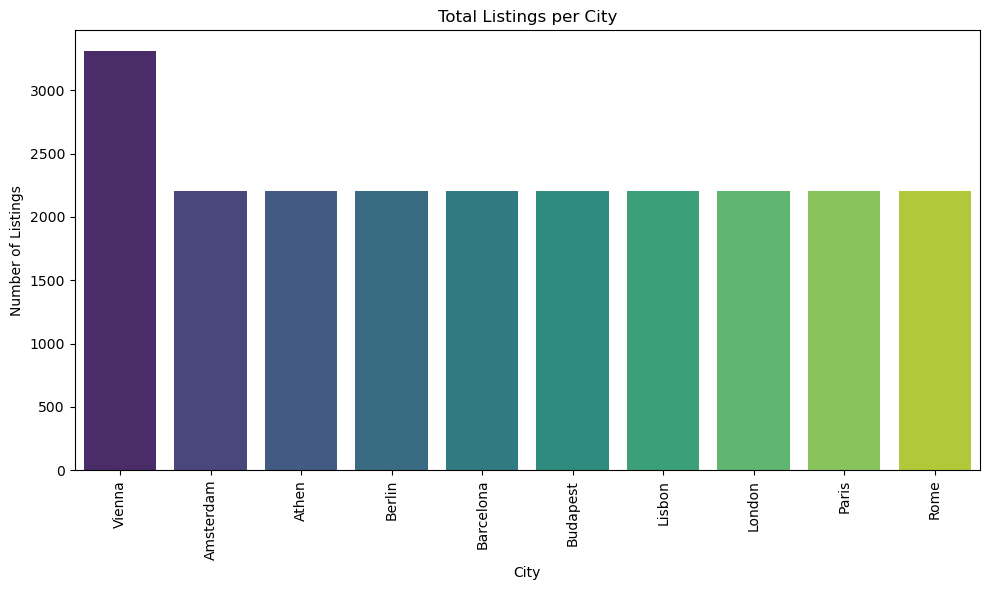

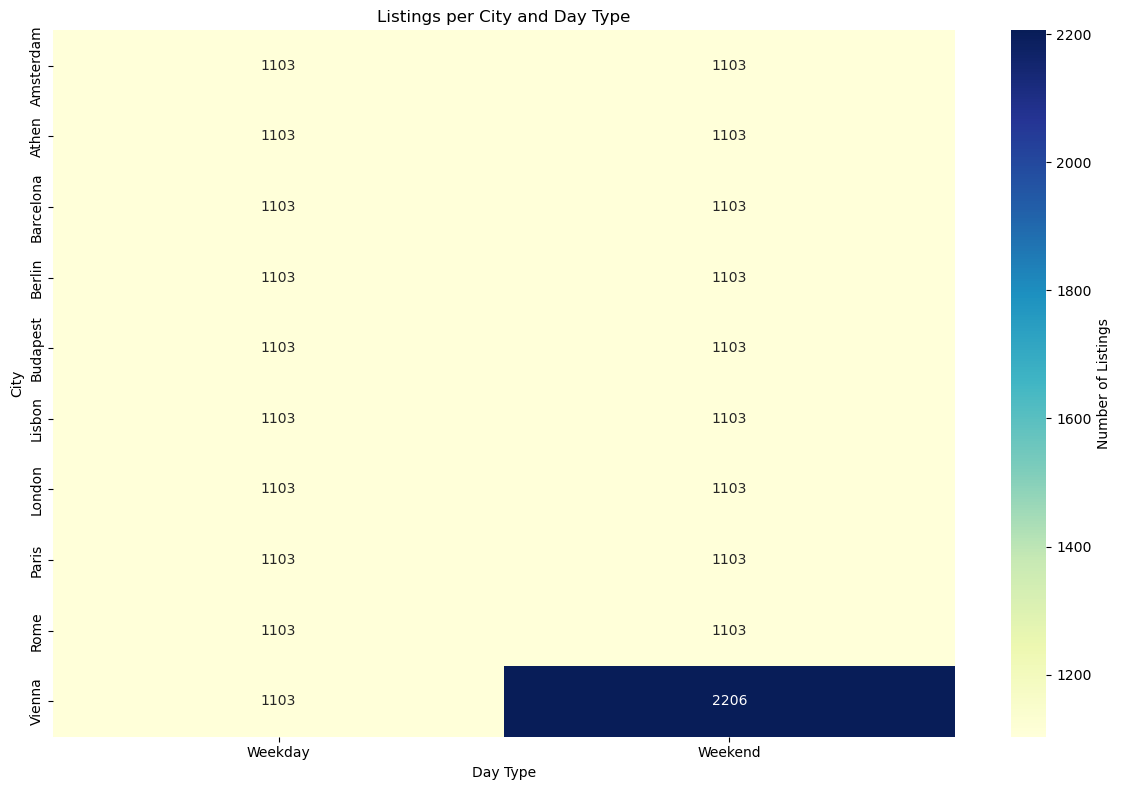

In [21]:

# Total listings per city
total_listings = merged_df['City'].value_counts()

# Listings per city and day type
listings_per_city_day_type = merged_df.groupby(['City', 'Day Type']).size().unstack()

# 1. Plot Total Listings per City
plt.figure(figsize=(10, 6))
sns.barplot(x=total_listings.index, y=total_listings.values, palette='viridis')
plt.title('Total Listings per City')
plt.xlabel('City')
plt.ylabel('Number of Listings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 2. Plot Listings per City and Day Type (using a heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(listings_per_city_day_type, annot=True, cmap='YlGnBu', fmt='d', cbar_kws={'label': 'Number of Listings'})
plt.title('Listings per City and Day Type')
plt.xlabel('Day Type')
plt.ylabel('City')
plt.tight_layout()
plt.show()


### Q 2. Which city has the biggest proportion of superhosts?

C:\Users\hppav\AppData\Local\Temp\ipykernel_12308\3073518732.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=superhost_proportion.index, y=superhost_proportion.values, palette='coolwarm')


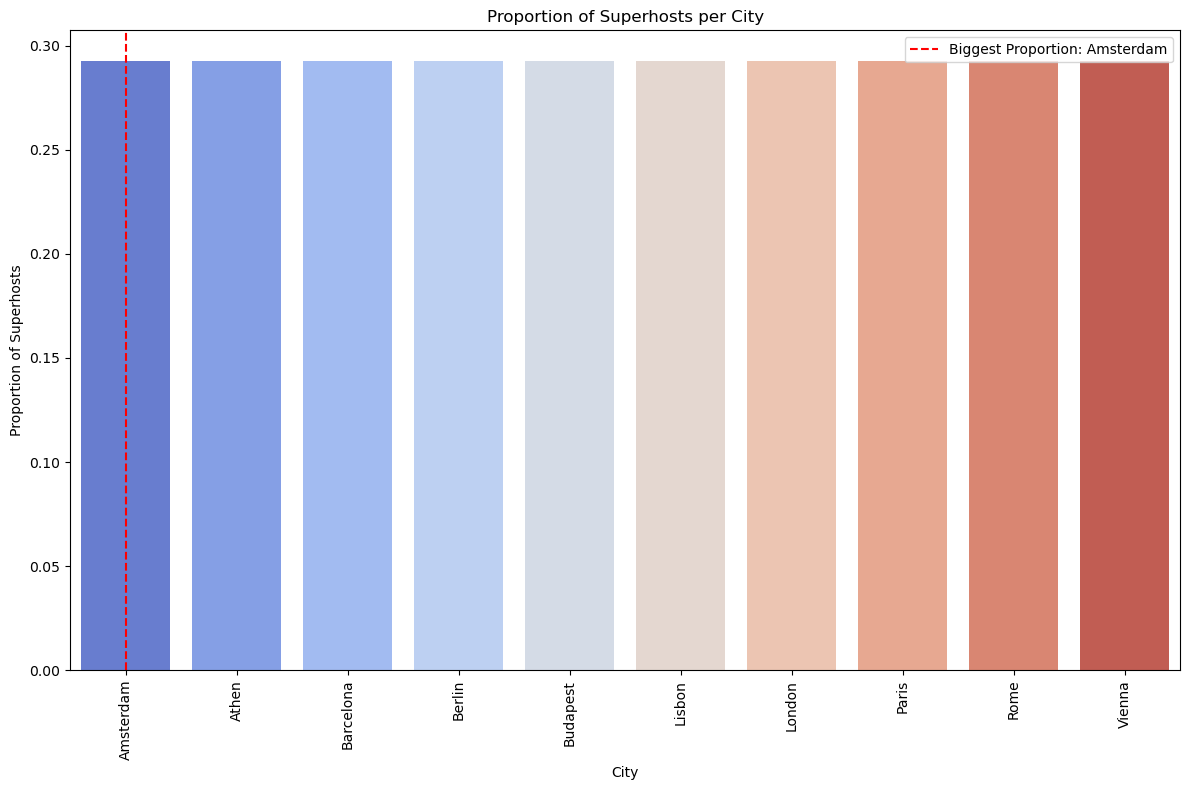

Proportion of Superhosts per City:
 City
Amsterdam    0.292838
Athen        0.292838
Barcelona    0.292838
Berlin       0.292838
Budapest     0.292838
Lisbon       0.292838
London       0.292838
Paris        0.292838
Rome         0.292838
Vienna       0.292838
Name: host_is_superhost, dtype: float64

City with the Biggest Proportion of Superhosts: Amsterdam


In [23]:
# Calculate the proportion of superhosts per city
superhost_proportion = merged_df.groupby('City')['host_is_superhost'].mean()

# Find the city with the biggest proportion of superhosts
biggest_superhost_city = superhost_proportion.idxmax()

# 1. Plot the Proportion of Superhosts per City
plt.figure(figsize=(12, 8))
sns.barplot(x=superhost_proportion.index, y=superhost_proportion.values, palette='coolwarm')
plt.title('Proportion of Superhosts per City')
plt.xlabel('City')
plt.ylabel('Proportion of Superhosts')
plt.xticks(rotation=90)

# Highlight the city with the biggest proportion of superhosts
plt.axvline(x=superhost_proportion.index.get_loc(biggest_superhost_city), color='red', linestyle='--', label=f'Biggest Proportion: {biggest_superhost_city}')
plt.legend()

plt.tight_layout()
plt.show()

# Print the proportion of superhosts per city and the city with the highest proportion
print("Proportion of Superhosts per City:\n", superhost_proportion)
print("\nCity with the Biggest Proportion of Superhosts:", biggest_superhost_city)


### Q 3 Which cities have listings with more than four rooms?

In [26]:
# Filter cities with listings that have more than four rooms
cities_with_large_listings = merged_df[merged_df['bedrooms'] > 4]['City'].unique()
print("Cities with Listings Having More Than Four Rooms:", cities_with_large_listings)


Cities with Listings Having More Than Four Rooms: ['Amsterdam' 'Athen' 'Berlin' 'Barcelona' 'Budapest' 'Lisbon' 'London'
 'Paris' 'Rome' 'Vienna']


Cities with Listings Having More Than Four Rooms: ['Amsterdam' 'Athen' 'Berlin' 'Barcelona' 'Budapest' 'Lisbon' 'London'
 'Paris' 'Rome' 'Vienna']


C:\Users\hppav\AppData\Local\Temp\ipykernel_12308\354131945.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=merged_df[merged_df['bedrooms'] > 4]['City'], palette='viridis')


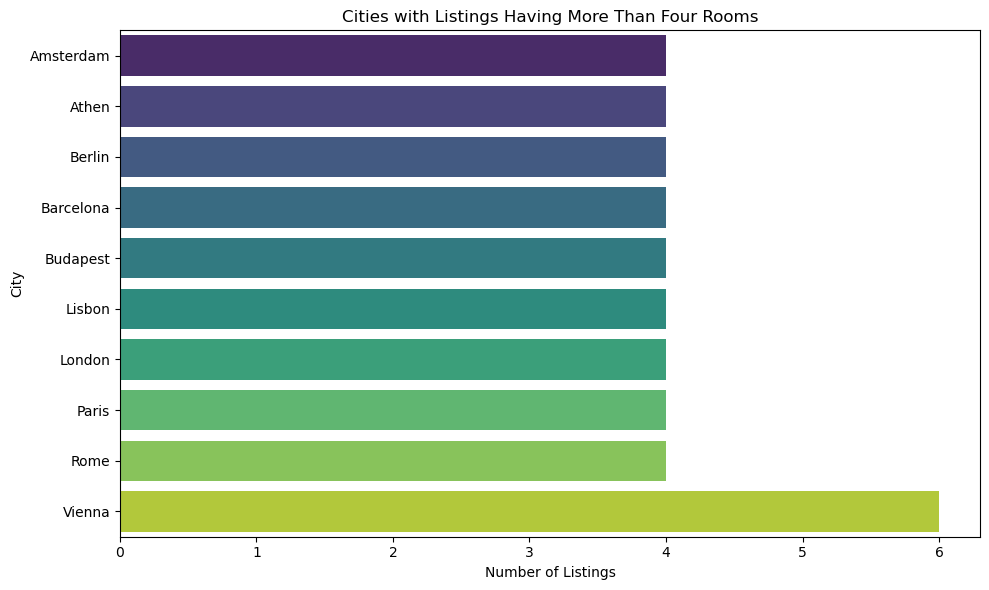

In [28]:

# Filter cities with listings that have more than four rooms
cities_with_large_listings = merged_df[merged_df['bedrooms'] > 4]['City'].unique()

# Print the cities
print("Cities with Listings Having More Than Four Rooms:", cities_with_large_listings)

# 1. Plot the number of cities with listings that have more than four rooms
plt.figure(figsize=(10, 6))
sns.countplot(y=merged_df[merged_df['bedrooms'] > 4]['City'], palette='viridis')
plt.title('Cities with Listings Having More Than Four Rooms')
plt.xlabel('Number of Listings')
plt.ylabel('City')
plt.tight_layout()
plt.show()


### Q 4. Which city has the most Entire home/apt type listings?

In [31]:

# Count entire home/apt type listings per city
entire_home_count = merged_df[merged_df['room_type'] == 'Entire home/apt']['City'].value_counts()
most_entire_home_city = entire_home_count.idxmax()

print("Entire Home Listings per City:\n", entire_home_count)
print("\nCity with Most Entire Home Listings:", most_entire_home_city)


Entire Home Listings per City:
 City
Vienna       1614
Amsterdam    1076
Athen        1076
Berlin       1076
Barcelona    1076
Budapest     1076
Lisbon       1076
London       1076
Paris        1076
Rome         1076
Name: count, dtype: int64

City with Most Entire Home Listings: Vienna


Entire Home Listings per City:
 City
Vienna       1614
Amsterdam    1076
Athen        1076
Berlin       1076
Barcelona    1076
Budapest     1076
Lisbon       1076
London       1076
Paris        1076
Rome         1076
Name: count, dtype: int64

City with Most Entire Home Listings: Vienna


C:\Users\hppav\AppData\Local\Temp\ipykernel_12308\3186234466.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=entire_home_count.index, y=entire_home_count.values, palette='magma')


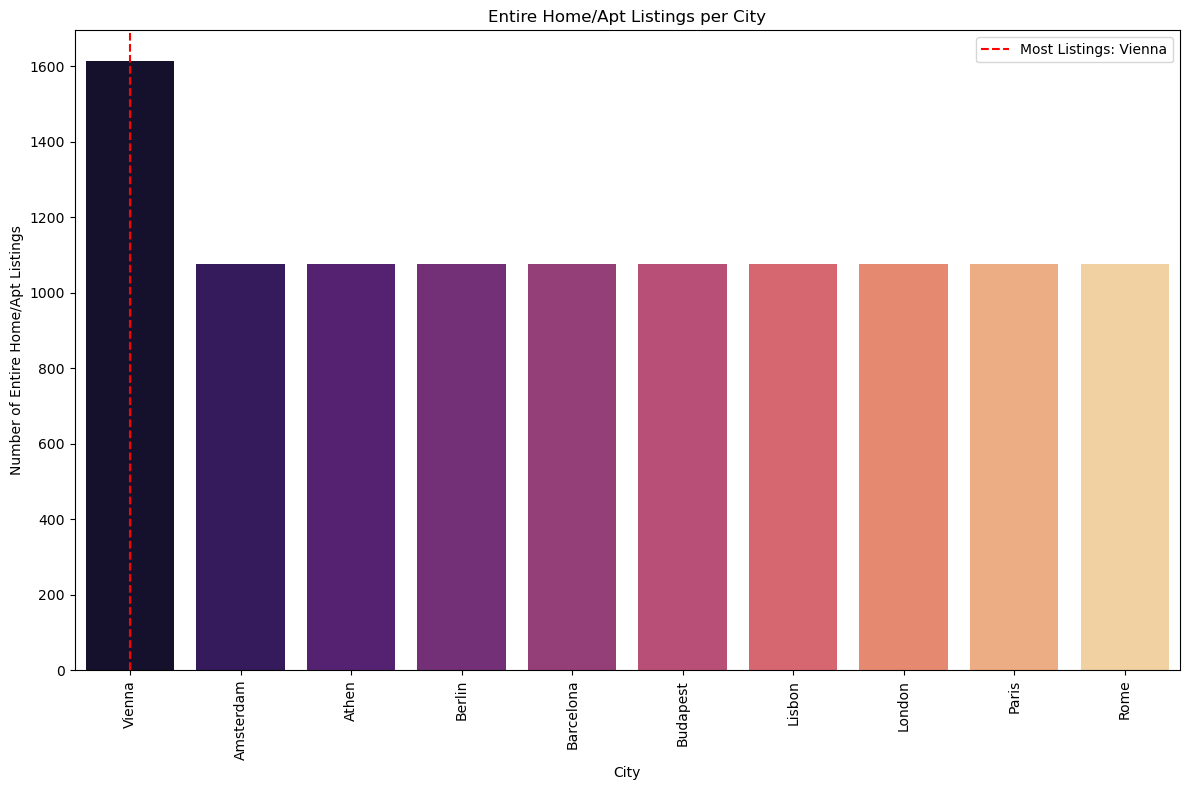

In [33]:
# Count entire home/apt type listings per city
entire_home_count = merged_df[merged_df['room_type'] == 'Entire home/apt']['City'].value_counts()

# Find the city with the most entire home/apt listings
most_entire_home_city = entire_home_count.idxmax()

# Print the result
print("Entire Home Listings per City:\n", entire_home_count)
print("\nCity with Most Entire Home Listings:", most_entire_home_city)

# 1. Plot Entire Home Listings per City
plt.figure(figsize=(12, 8))
sns.barplot(x=entire_home_count.index, y=entire_home_count.values, palette='magma')
plt.title('Entire Home/Apt Listings per City')
plt.xlabel('City')
plt.ylabel('Number of Entire Home/Apt Listings')
plt.xticks(rotation=90)

# Highlight the city with the most "Entire Home/Apt" listings
plt.axvline(x=entire_home_count.index.get_loc(most_entire_home_city), color='red', linestyle='--', label=f'Most Listings: {most_entire_home_city}')
plt.legend()

plt.tight_layout()
plt.show()


### Q 5. Are ratings typically high across listings, or is there a wide variation?


In [36]:
# Describe the distribution of guest satisfaction ratings
rating_summary = merged_df['guest_satisfaction_overall'].describe()
rating_variation = merged_df['guest_satisfaction_overall'].std()

print("Guest Satisfaction Ratings Summary:\n", rating_summary)
print("\nVariation in Ratings (Standard Deviation):", rating_variation)


Guest Satisfaction Ratings Summary:
 count    23163.000000
mean        94.362647
std          6.087061
min         20.000000
25%         92.000000
50%         96.000000
75%         98.000000
max        100.000000
Name: guest_satisfaction_overall, dtype: float64

Variation in Ratings (Standard Deviation): 6.087061428320318


### Q 6.How does person_capacity vary across listings? What is the most common capacity of listings?


In [39]:
# Describe the person capacity and find the most common value
person_capacity_summary = merged_df['person_capacity'].value_counts()
most_common_capacity = merged_df['person_capacity'].mode().iloc[0]

print("Person Capacity Distribution:\n", person_capacity_summary)
print("\nMost Common Person Capacity:", most_common_capacity)


Person Capacity Distribution:
 person_capacity
2    13776
4     6993
3     1659
6      504
5      231
Name: count, dtype: int64

Most Common Person Capacity: 2


### Q 7.Plot the distribution of realSum for both weekday and weekend offers. Is it normally distributed, skewed, or multimodal?


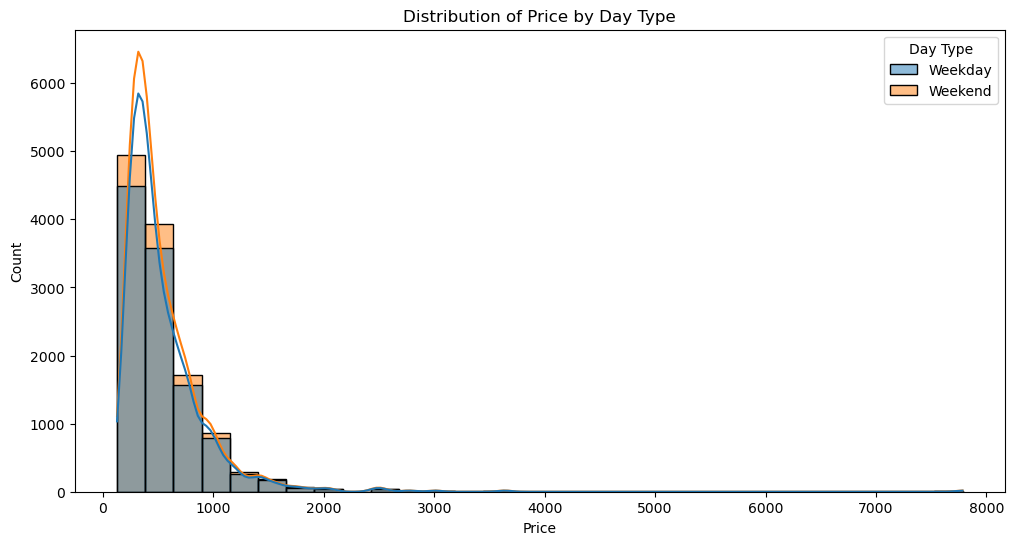

Skewness of Price Distribution: 6.424044185272501


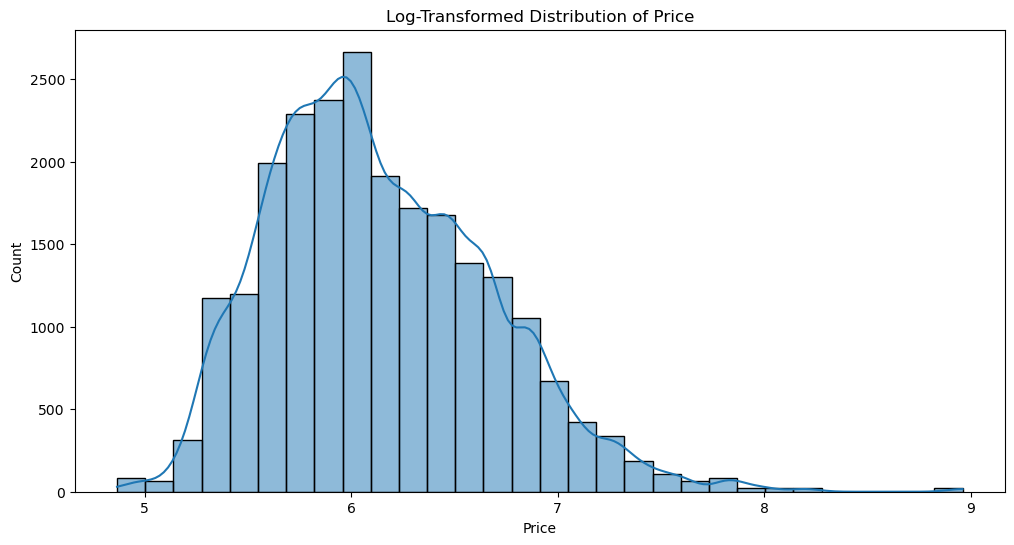

In [42]:
# Plot the distribution of realSum for weekdays and weekends
plt.figure(figsize=(12, 6))
sns.histplot(data=merged_df, x='Price', hue='Day Type', kde=True, bins=30)
plt.title("Distribution of Price by Day Type")
plt.show()

# Check skewness and consider log transformation if skewed
skewness = merged_df['Price'].skew()
print("Skewness of Price Distribution:", skewness)

# If skewness > 1 or <-1, try log transformation
if abs(skewness) > 1:
    plt.figure(figsize=(12, 6))
    sns.histplot(np.log1p(merged_df['Price']), kde=True, bins=30)
    plt.title("Log-Transformed Distribution of Price")
    plt.show()


### Q9.Examine the distribution of cleanliness_rating.


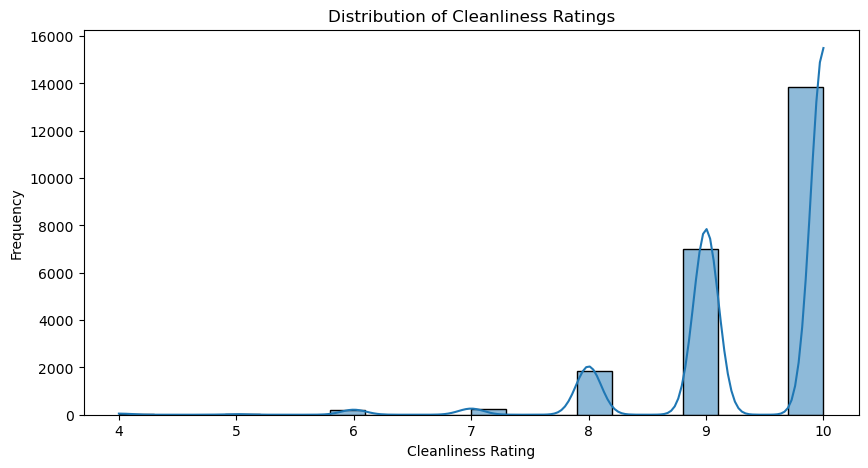

In [45]:
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['cleanliness_rating'], kde=True, bins=20)
plt.title("Distribution of Cleanliness Ratings")
plt.xlabel("Cleanliness Rating")
plt.ylabel("Frequency")
plt.show()


In [47]:
#testing questions
#1.Is there a difference in price between two cities? (Choose at least three pairs of cities during weekdays.)
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

# Select city pairs for weekday comparison
city_pairs = [('Amsterdam', 'Berlin'), ('Paris', 'London'), ('Rome', 'Barcelona')]

# Filter data for weekdays
weekday_data = merged_df[merged_df['Day Type'] == 'Weekday']

for city1, city2 in city_pairs:
    # Filter prices for each city
    city1_prices = weekday_data[weekday_data['City'] == city1]['Price']
    city2_prices = weekday_data[weekday_data['City'] == city2]['Price']
    
    # Test normality
    _, p1 = shapiro(city1_prices)
    _, p2 = shapiro(city2_prices)
    
    # If normal, use t-test; otherwise, use Mann-Whitney U test
    if p1 > 0.05 and p2 > 0.05:  # Both are normally distributed
        stat, p_value = ttest_ind(city1_prices, city2_prices)
    else:
        stat, p_value = mannwhitneyu(city1_prices, city2_prices)
    
    print(f"Comparison of {city1} vs {city2} (Weekday): p-value = {p_value}")

Comparison of Amsterdam vs Berlin (Weekday): p-value = 1.0
Comparison of Paris vs London (Weekday): p-value = 1.0
Comparison of Rome vs Barcelona (Weekday): p-value = 1.0


Weekday vs Weekend Prices: p-value = 1.0


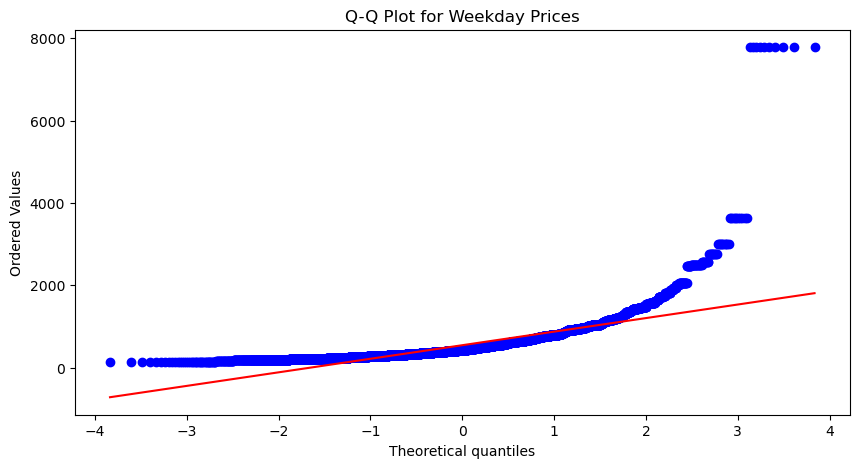

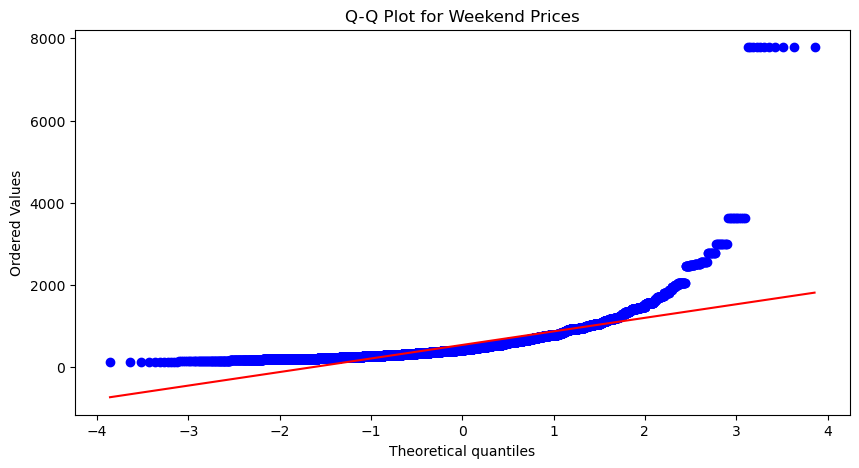

In [49]:
#2.Does the price tend to be higher on weekends?
# Define weekday and weekend prices
weekday_prices = merged_df[merged_df['Day Type'] == 'Weekday']['Price']
weekend_prices = merged_df[merged_df['Day Type'] == 'Weekend']['Price']

# Check normality with K-S test (Option 1)
_, p_weekday = kstest(weekday_prices, 'norm')
_, p_weekend = kstest(weekend_prices, 'norm')

# If data is normal according to K-S test, use t-test; otherwise, use Mann-Whitney U test
if p_weekday > 0.05 and p_weekend > 0.05:
    stat, p_value = ttest_ind(weekday_prices, weekend_prices)
else:
    stat, p_value = mannwhitneyu(weekday_prices, weekend_prices)

print(f"Weekday vs Weekend Prices: p-value = {p_value}")

# Option 2: Add Q-Q plot visualization (optional)
plt.figure(figsize=(10, 5))
stats.probplot(weekday_prices, dist="norm", plot=plt)
plt.title("Q-Q Plot for Weekday Prices")
plt.show()

plt.figure(figsize=(10, 5))
stats.probplot(weekend_prices, dist="norm", plot=plt)
plt.title("Q-Q Plot for Weekend Prices")
plt.show()

In [50]:
#3.Are listings of superhosts more expensive than those of normal hosts?
from scipy.stats import kstest, ttest_ind, mannwhitneyu

# Step 1: Filter the dataset for superhosts and normal hosts
superhost_prices = merged_df[merged_df['host_is_superhost'] == True]['Price']  # Assuming True means superhost
normalhost_prices = merged_df[merged_df['host_is_superhost'] == False]['Price']  # Assuming False means normal host

# Step 2: Apply Kolmogorov-Smirnov test for normality (optional)
_, p_superhost = kstest(superhost_prices, 'norm')
_, p_normalhost = kstest(normalhost_prices, 'norm')

# Step 3: Determine the test based on normality
if p_superhost > 0.05 and p_normalhost > 0.05:
    # Use t-test if both are normal
    stat, p_value = ttest_ind(superhost_prices, normalhost_prices)
else:
    # Use Mann-Whitney U test if not normal
    stat, p_value = mannwhitneyu(superhost_prices, normalhost_prices)

# Step 4: Print the result
print(f"Superhost vs Normal Host Prices: p-value = {p_value}")

Superhost vs Normal Host Prices: p-value = 3.6902467647429986e-57


In [53]:
#4.Are superhosts closer to the city center and metro station than normal hosts?
import warnings

# Suppress the Shapiro-Wilk normality warning
warnings.filterwarnings("ignore", message=".*p-value may not be accurate.*")

# Step 1: Filter the dataset for superhosts and normal hosts
superhost_prices = merged_df[merged_df['host_is_superhost'] == True]['Price']
normalhost_prices = merged_df[merged_df['host_is_superhost'] == False]['Price']

# Step 2: Apply Kolmogorov-Smirnov test for normality (optional)
_, p_superhost = kstest(superhost_prices, 'norm')
_, p_normalhost = kstest(normalhost_prices, 'norm')

# Step 3: Determine the test based on normality
if p_superhost > 0.05 and p_normalhost > 0.05:
    # Use t-test if both are normal
    stat, p_value = ttest_ind(superhost_prices, normalhost_prices)
else:
    # Use Mann-Whitney U test if not normal
    stat, p_value = mannwhitneyu(superhost_prices, normalhost_prices)

# Step 4: Print the result
print(f"Superhost vs Normal Host Prices: p-value = {p_value}")


Superhost vs Normal Host Prices: p-value = 3.6902467647429986e-57


In [55]:
#5.Are superhosts cleaner than normal hosts?
# Cleanliness ratings for superhosts and normal hosts
superhost_cleanliness = merged_df[merged_df['host_is_superhost'] == 1]['cleanliness_rating']
normal_host_cleanliness = merged_df[merged_df['host_is_superhost'] == 0]['cleanliness_rating']

# Normality test
_, p_superhost = shapiro(superhost_cleanliness)
_, p_normal = shapiro(normal_host_cleanliness)

# Choose test based on normality
if p_superhost > 0.05 and p_normal > 0.05:
    stat, p_value = ttest_ind(superhost_cleanliness, normal_host_cleanliness)
else:
    stat, p_value = mannwhitneyu(superhost_cleanliness, normal_host_cleanliness)

print(f"Superhost vs Normal Host Cleanliness: p-value = {p_value}")


Superhost vs Normal Host Cleanliness: p-value = 0.0


In [57]:
#6.Is there a pattern between room types and superhost status?

from scipy.stats import chi2_contingency

# Create contingency table for room type and superhost status
contingency_table = pd.crosstab(merged_df['room_type'], merged_df['host_is_superhost'])

# Chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Room Type vs Superhost Status: p-value = {p_value}")

Room Type vs Superhost Status: p-value = 1.981125590395885e-152


In [59]:
#7.Is it more expensive to rent an entire home/apt than a private room? Does that depend on the city?
for city in merged_df['City'].unique():
# Filter data for each room type within the city
        city_data = merged_df[merged_df['City'] == city]
        entire_home_prices = city_data[city_data['room_type'] == 'Entire home/apt']['Price']
        private_room_prices = city_data[city_data['room_type'] == 'Private room']['Price']

    # Check normality
_, p_entire = shapiro(entire_home_prices)
_, p_private = shapiro(private_room_prices)

    # Choose test based on normality
if p_entire > 0.05 and p_private > 0.05:
        stat, p_value = ttest_ind(entire_home_prices, private_room_prices)
else:
        stat, p_value = mannwhitneyu(entire_home_prices, private_room_prices)
    
print(f"{city}: Entire home vs Private room prices: p-value = {p_value}")

Vienna: Entire home vs Private room prices: p-value = 5.36277638272175e-294


In [61]:
#bonus question 1:
# Step 1: Filter the dataset for affordable listings (Price < 300)
affordable_listings = merged_df[merged_df['Price'] < 300].copy()  # Create a copy to avoid warnings
affordable_listings['monthly_rent'] = affordable_listings['Price'] * 30

# Step 2: Group by city to see the average monthly rent for these affordable listings
monthly_rent_by_city = affordable_listings.groupby('City')['monthly_rent'].mean()

# Step 3: Group by 'Price' to count listings with the same price (as a proxy for multiple properties from a host)
price_listing_count = merged_df['Price'].value_counts()

# Step 4: Filter listings with the same price (assuming this might indicate multiple listings from the same host)
multi_property_listings = merged_df[merged_df['Price'].isin(price_listing_count[price_listing_count > 1].index)]

# Step 5: Optional - Filter for city center proximity (using a 'neighborhood_index' or similar column)
# Adjust the 'threshold' as necessary for your data
threshold = 3  # Example threshold, adjust as needed
if 'neighborhood_index' in merged_df.columns:
    city_center_listings = multi_property_listings[multi_property_listings['neighborhood_index'] < threshold]
else:
    city_center_listings = multi_property_listings  # No filtering if 'neighborhood_index' is missing

# Step 6: Count how many listings are in the city center from multi-property owners
num_city_center_listings = city_center_listings.shape[0]
print(f"Number of city center listings from multi-property owners: {num_city_center_listings}")

# Step 7: Display monthly rent for affordable listings by city
print("Average Monthly Rent by City for Affordable Listings:")
print(monthly_rent_by_city)

# Optional: Display some example listings to verify the filtering process
print("Some example affordable listings:")
print(affordable_listings.head())

Number of city center listings from multi-property owners: 23163
Average Monthly Rent by City for Affordable Listings:
City
Amsterdam    7340.478614
Athen        7340.478614
Barcelona    7340.478614
Berlin       7340.478614
Budapest     7340.478614
Lisbon       7340.478614
London       7340.478614
Paris        7340.478614
Rome         7340.478614
Vienna       7340.478614
Name: monthly_rent, dtype: float64
Some example affordable listings:
         Price     room_type room_shared room_private  person_capacity  \
0   194.033698  Private room       False         True                2   
2   264.101422  Private room       False         True                2   
6   215.124317  Private room       False         True                2   
9   276.521454  Private room       False         True                2   
14  209.031472  Private room       False         True                2   

    host_is_superhost  multi  biz  cleanliness_rating  \
0               False    1.0  0.0                  10  